## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

Populating the interactive namespace from numpy and matplotlib


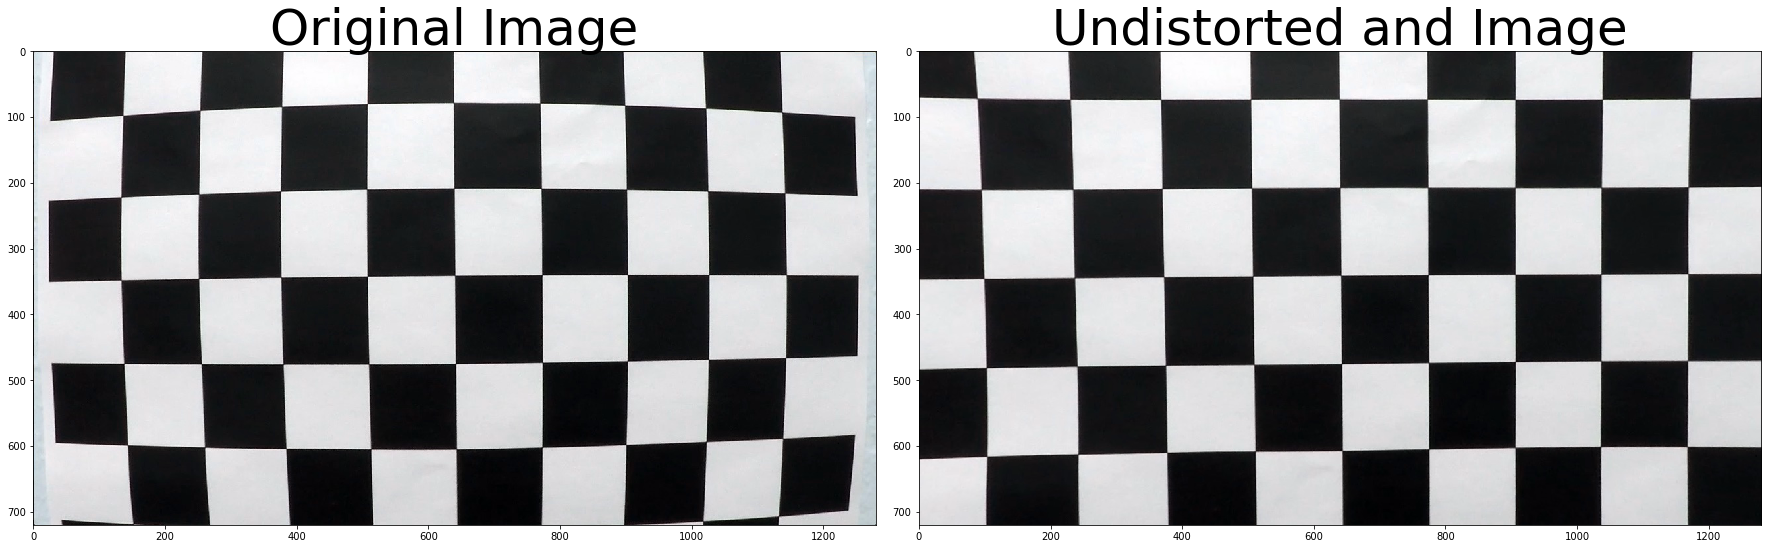

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt
%pylab inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

# Calibrate camera based on the objpoints and the imgpoints obtained previously
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Method to simply the obtaintion of an undistort image
def getUndistortImage(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

img = cv2.imread('camera_cal/calibration1.jpg')
dst = getUndistortImage(img)

# displaying image comparison
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted and Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Apply a distortion correction to raw images.

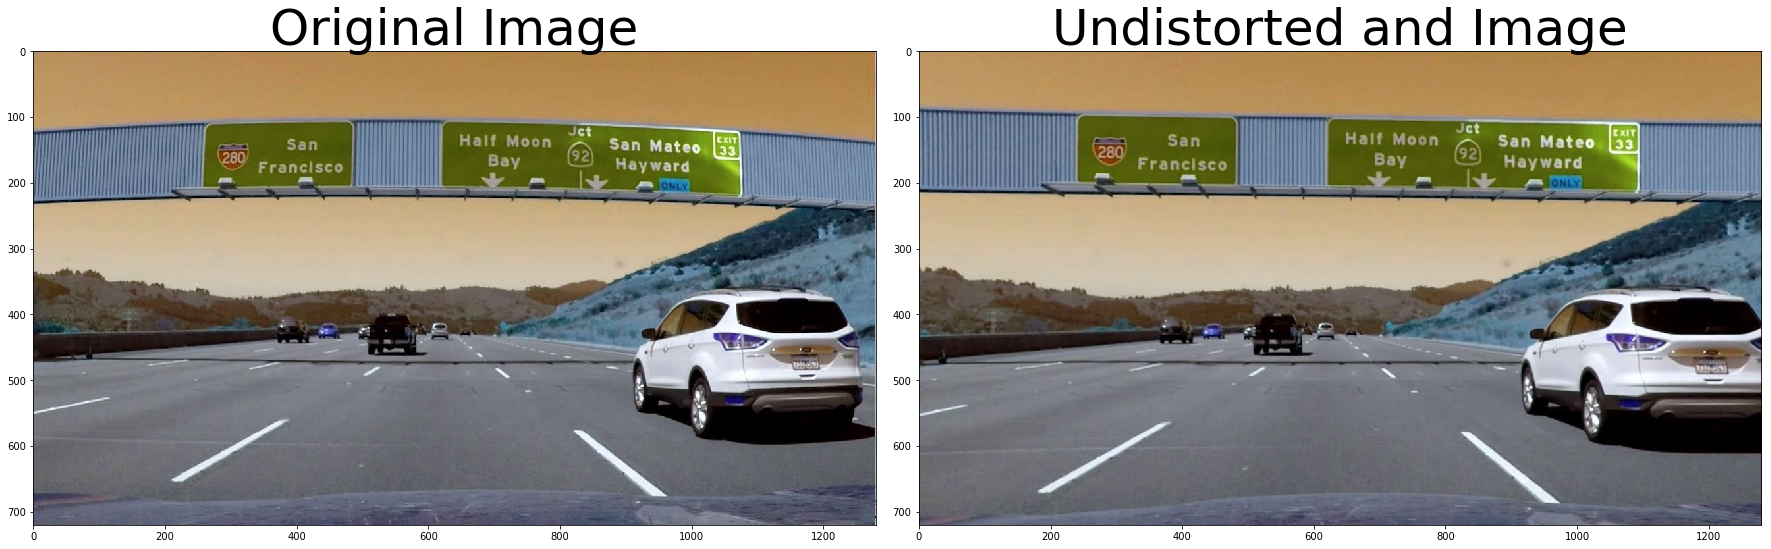

In [2]:
# Apply a distortion correction to raw images.

# Test Image to work
test_img = cv2.imread('test_images/udacity.jpg')
dst = getUndistortImage(test_img)

# displaying image comparison
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted and Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Use color transforms, gradients, etc., to create a thresholded binary image.

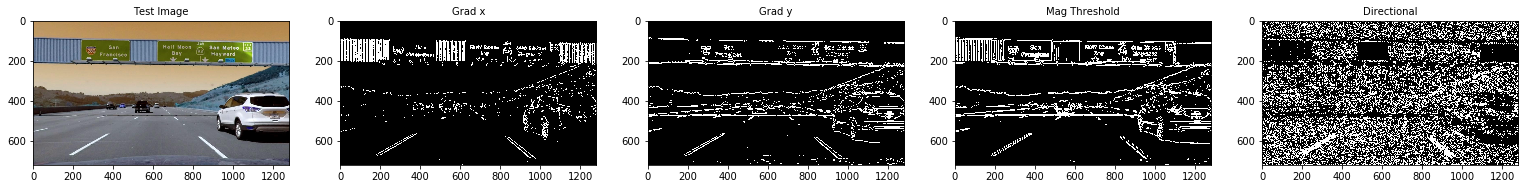

In [3]:
# Apply a distortion correction to raw images.

# Support methods to calculate masks for gradients
def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    #scale_factor = np.max(abs_sobel)/255 
    #scaled_sobel = (abs_sobel/scale_factor).astype(np.uint8) 
    scaled_sobel = (255*abs_sobel/np.max(abs_sobel)).astype(np.uint8) 
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    arctan2 = np.arctan2(abs_sobely, abs_sobelx)
    #scaled_sobel = np.uint8(255*arctan2/np.max(arctan2))
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(arctan2)
    binary_output[(arctan2 >= thresh[0]) & (arctan2 <= thresh[1])] = 1
    return binary_output

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Test Image to work
test_img = cv2.imread('test_images/udacity.jpg')
test_img = getUndistortImage(test_img)

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(test_img, orient='x', thresh=(20, 100))
grady = abs_sobel_thresh(test_img, orient='y', thresh=(20, 100))
mag_binary = mag_thresh(test_img, sobel_kernel=9, mag_thresh=(30, 100))
dir_binary = dir_threshold(test_img, sobel_kernel=15, thresh=(0.7, 1.3))

# Show preprocessed images
fig = plt.figure(figsize=(25,15))

img_plot = fig.add_subplot(1, 5, 1)
plt.imshow(test_img, cmap='gray')
img_plot.set_title("Test Image", size=10)

img_plot = fig.add_subplot(1, 5, 2)
plt.imshow(gradx, cmap='gray')
img_plot.set_title("Grad x", size=10)

img_plot = fig.add_subplot(1, 5, 3)
plt.imshow(grady, cmap='gray')
img_plot.set_title("Grad y", size=10)

img_plot = fig.add_subplot(1, 5, 4)
plt.imshow(mag_binary, cmap='gray')
img_plot.set_title("Mag Threshold", size=10)

img_plot = fig.add_subplot(1, 5, 5)
plt.imshow(dir_binary, cmap='gray')
img_plot.set_title("Directional", size=10)

fig.subplots_adjust(bottom=0.05, right=0.95)
plt.show()


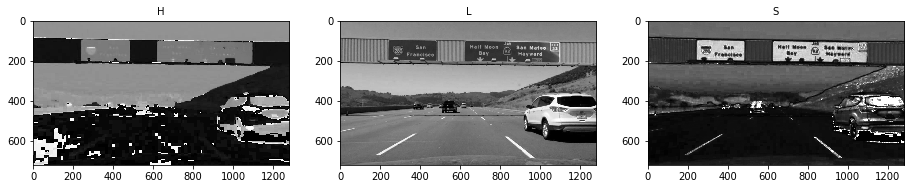

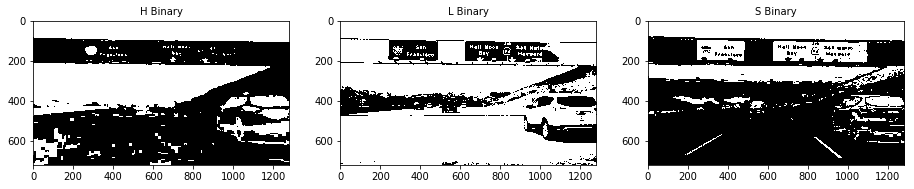

In [4]:
def getHLS(img, channel='S', thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    if channel == "HB":
        binary[(H >= thresh[0]) & (H <= thresh[1])] = 1
    if channel == "H":
        return H
    if channel == "LB":
        binary[(L >= thresh[0]) & (L <= thresh[1])] = 1
    if channel == "L":
        return L
    if channel == "SB":
        binary[(S >= thresh[0]) & (S <= thresh[1])] = 1
    if channel == "S":
        return S
    
    kernel = np.ones((5,5), np.uint8)
    dilated = cv2.dilate(binary, kernel, iterations=3)
    return binary

# Test Image to work
test_img = cv2.imread('test_images/udacity.jpg')
test_img = getUndistortImage(test_img)

# Show preprocessed images
fig = plt.figure(figsize=(25,15))

img_plot = fig.add_subplot(1, 5, 1)
plt.imshow(getHLS(test_img, 'H', (90,100)), cmap="gray")
img_plot.set_title("H", size=10)

img_plot = fig.add_subplot(1, 5, 2)
plt.imshow(getHLS(test_img, 'L', (10,255)), cmap="gray")
img_plot.set_title("L", size=10)

img_plot = fig.add_subplot(1, 5, 3)
plt.imshow(getHLS(test_img, 'S', (90,255)), cmap="gray")
img_plot.set_title("S", size=10)

fig.subplots_adjust(bottom=0.05, right=0.95)
plt.show()

fig = plt.figure(figsize=(25,15))

img_plot = fig.add_subplot(1, 5, 1)
plt.imshow(getHLS(test_img, 'HB', (90,255)), cmap="gray")
img_plot.set_title("H Binary", size=10)

img_plot = fig.add_subplot(1, 5, 2)
plt.imshow(getHLS(test_img, 'LB', (90,255)), cmap="gray")
img_plot.set_title("L Binary", size=10)

img_plot = fig.add_subplot(1, 5, 3)
plt.imshow(getHLS(test_img, 'SB', (90,255)), cmap="gray")
img_plot.set_title("S Binary", size=10)

fig.subplots_adjust(bottom=0.05, right=0.95)
plt.show()

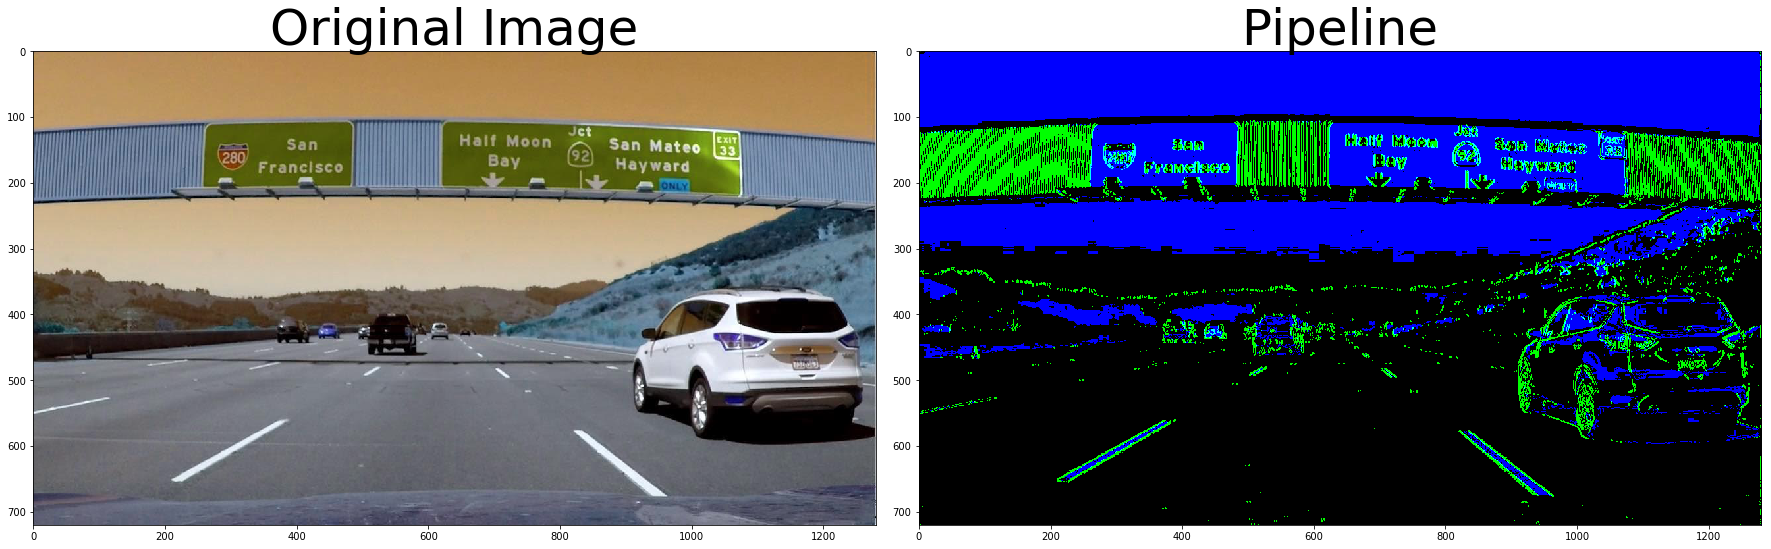

In [62]:
# Method used to preprocess image before sending it to line detection
# Pipeline:
# Requires BGR Image
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary

# Test Image to work
test_img = cv2.imread('test_images/udacity.jpg')
pipeline_image = pipeline(test_img, s_thresh=(90,250))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(pipeline_image)
ax2.set_title('Pipeline', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Apply a perspective transform to rectify binary image ("birds-eye view").

Size: 1280x720


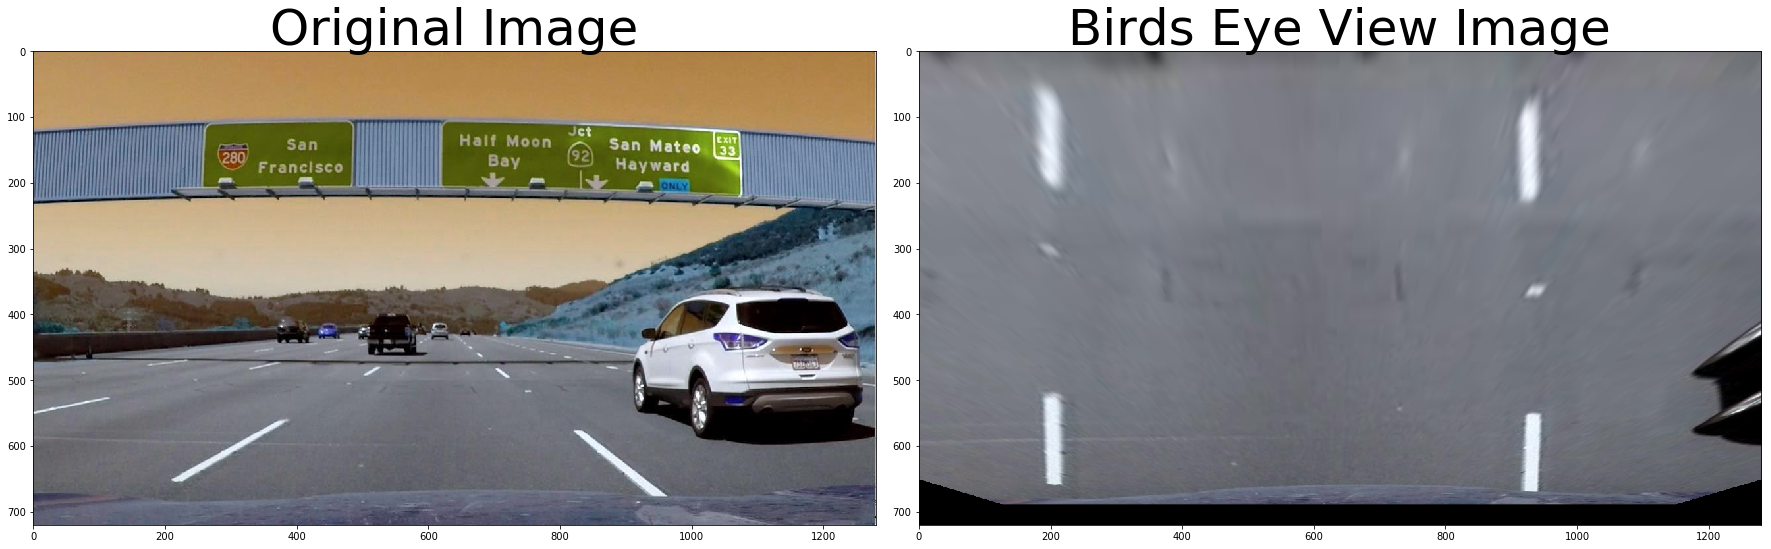

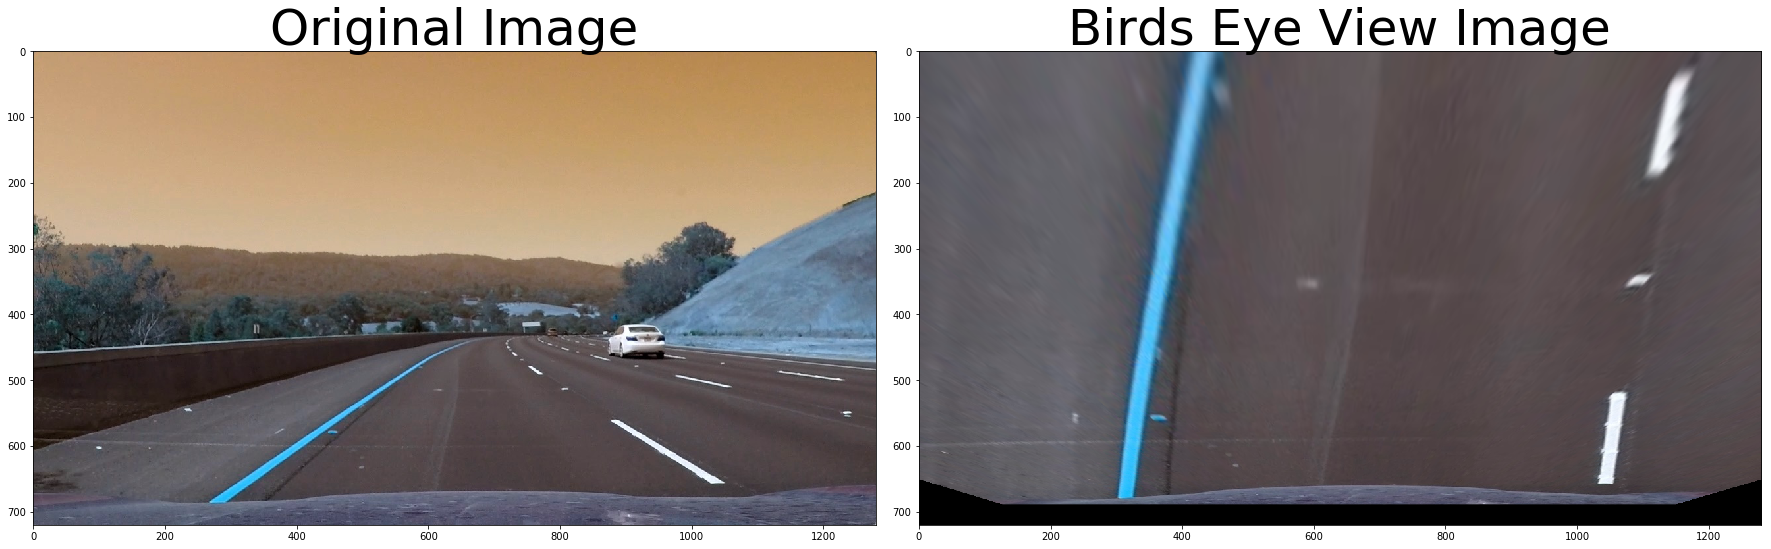

In [6]:
# Apply a perspective transform to rectify binary image ("birds-eye view").

# Requires BGR Image
def birds_eye_view(img):
    # Pass in your image into this function
    # 1) Undistort using mtx and dist
    undist = getUndistortImage(img)
    # source points and dst points found via image editor
    src = np.float32([[220,660],[530,480],[940,660],[705,480]])
    dst = np.float32([[220,650],[220,60],[940,650],[940,60]])
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    # Convert to grayscaly since warpPerspective needs it
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # using 8 points interpolation to minimize the loose of resolution (faster option: INTER_LINEAR)
    warped = cv2.warpPerspective(undist, M, gray.shape[::-1], flags=cv2.INTER_LANCZOS4)
    return warped, M, Minv

# Test Image to work
test_img = cv2.imread('test_images/udacity.jpg')
height, width, channels = img.shape
print("Size: {}x{}".format(width, height))
top_down, perspective_M, Minv = birds_eye_view(test_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Birds Eye View Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Test Image to work
test_img = cv2.imread('test_images/test3.jpg')
##################################################
top_down, perspective_M, Minv = birds_eye_view(test_img)
##################################################

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Birds Eye View Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Detect lane pixels and fit to find the lane boundary.

In [73]:
# Line helper class
class Line():
    offset = 0
    def __init__(self, color = None):
        # was the line detected in the last iteration?
        self.confidence = 0
        self.detected = False
        self.detected = False  
        
        # radius
        self.radius_of_curvature = None 
        
        self.leftx = None
        self.lefty = None 
        self.rightx = None
        self.righty = None
        
        self.leftx_a = [None]
        self.lefty_a = [None] 
        self.rightx_a = [None]
        self.righty_a = [None]
        
        self.ploty = None
        self.left_fitx = None
        self.right_fitx = None
        self.left_fit = None
        self.right_fit = None
        
        self.left_curvature = None
        self.right_curvature = None
        self.pixels_off_center = None
        self.pixels_in_lane = None
        
        self.image = None
        self.color = color
    
    def get_off_center_meters(self):
        # lanes are 3.7m
        xm_per_pix = 3.7/self.pixels_in_lane
        return xm_per_pix * self.pixels_off_center
    
    # Expects a binary image
    def findLines(self, binary_warped):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
        # Create an output image to draw on and  visualize the result
        self.image = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        self.pixels_in_lane = abs(rightx_base - leftx_base)
        self.pixels_off_center = abs(midpoint - leftx_base) - abs(midpoint - rightx_base)
        #print("Off center: {}".format(self.pixels_off_center))
        #print("Pixels in lane: {}".format(self.pixels_in_lane))
        #print("midpoint: {}".format(midpoint))

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(self.image, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (0,255,0), 2) 
            cv2.rectangle(self.image, (win_xright_low,win_y_low), (win_xright_high,win_y_high), (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # fit polynomious based on last 20 frames points
        self.lefty_a.append(lefty)
        self.leftx_a.append(leftx)
        self.rightx_a.append(rightx)
        self.righty_a.append(righty)

        #print("lefty: {}".format(lefty))
        #print("self.lefty_a: {}".format(self.lefty_a))

        lefty_tmp = []
        leftx_tmp = []
        righty_tmp = []
        rightx_tmp = []
        for i in range (max(1, len(self.lefty_a) - 10), len(self.lefty_a)):
            lefty_tmp.extend(self.lefty_a[i])
            leftx_tmp.extend(self.leftx_a[i])
            righty_tmp.extend(self.righty_a[i])
            rightx_tmp.extend(self.rightx_a[i])
        
        #print("lefty_tmp: {}".format(lefty_tmp))
        #print("self.lefty_a: {}".format(self.lefty_a))
                    
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty_tmp, leftx_tmp, 2)
        right_fit = np.polyfit(righty_tmp, rightx_tmp, 2)
        '''
        if not np.any(leftx) or not np.any(lefty) or not np.any(rightx) or not np.any(righty):
            leftx = self.leftx
            lefty = self.lefty
            rightx = self.rightx
            righty = self.righty
            left_fit = self.left_fit
            right_fit = self.right_fit
        else:
            # Fit a second order polynomial to each
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
            self.left_fit = left_fit
            self.right_fit = right_fit
            self.leftx = leftx
            self.lefty = lefty
            self.rightx = rightx
            self.righty = righty
        '''
        # VISUALIZATION
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Calculate curvature
        y_eval = np.max(ploty)
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        self.left_curvature = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        self.right_curvature = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        #if not self.left_curvature:
        #    self.left_curvature = left_curvature
        #    self.right_curvature = right_curvature
        #else:
        #    if abs(left_curvature - self.left_curvature) > 500 or abs(right_curvature - self.right_curvature) > 500 :
                # we must discard dis poly and used previous
                

        self.image[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        self.image[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        #plt.imshow(out_img)
        #plt.plot(left_fitx, ploty, color='yellow')
        #plt.plot(right_fitx, ploty, color='yellow')
        #plt.xlim(0, 1280)
        #plt.ylim(720, 0)
        return self.image, left_fit, right_fit, ploty, left_fitx, right_fitx

    # Curveture in Real World (meters)
    def getRealWorldCurve(self):
        return self.left_curvature, self.right_curvature

Size: 1280x720


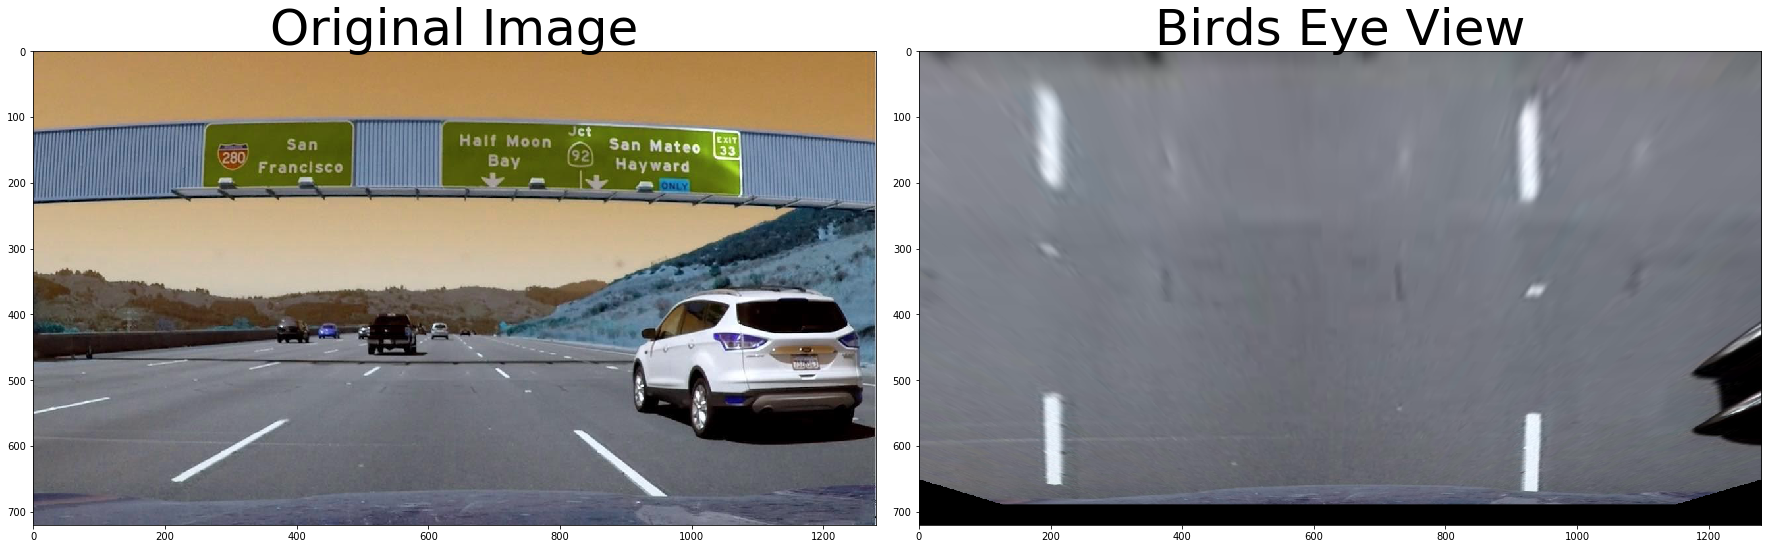

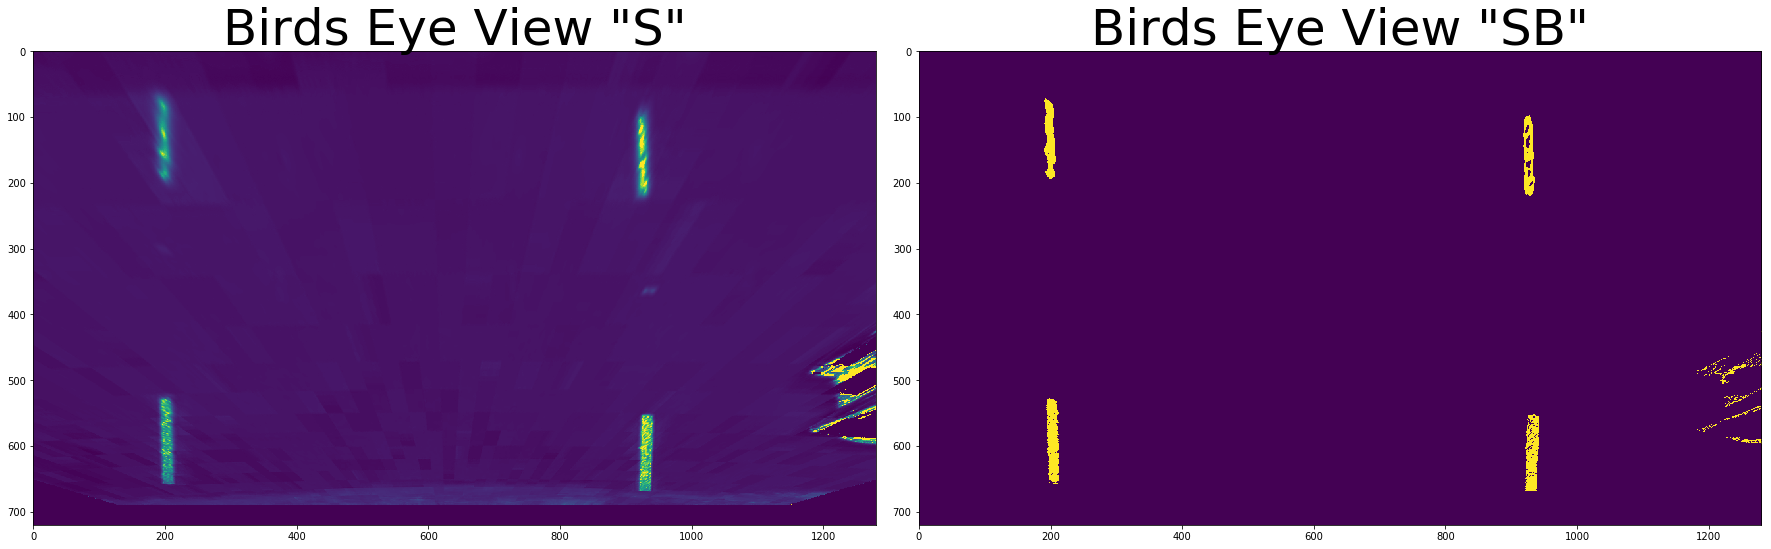

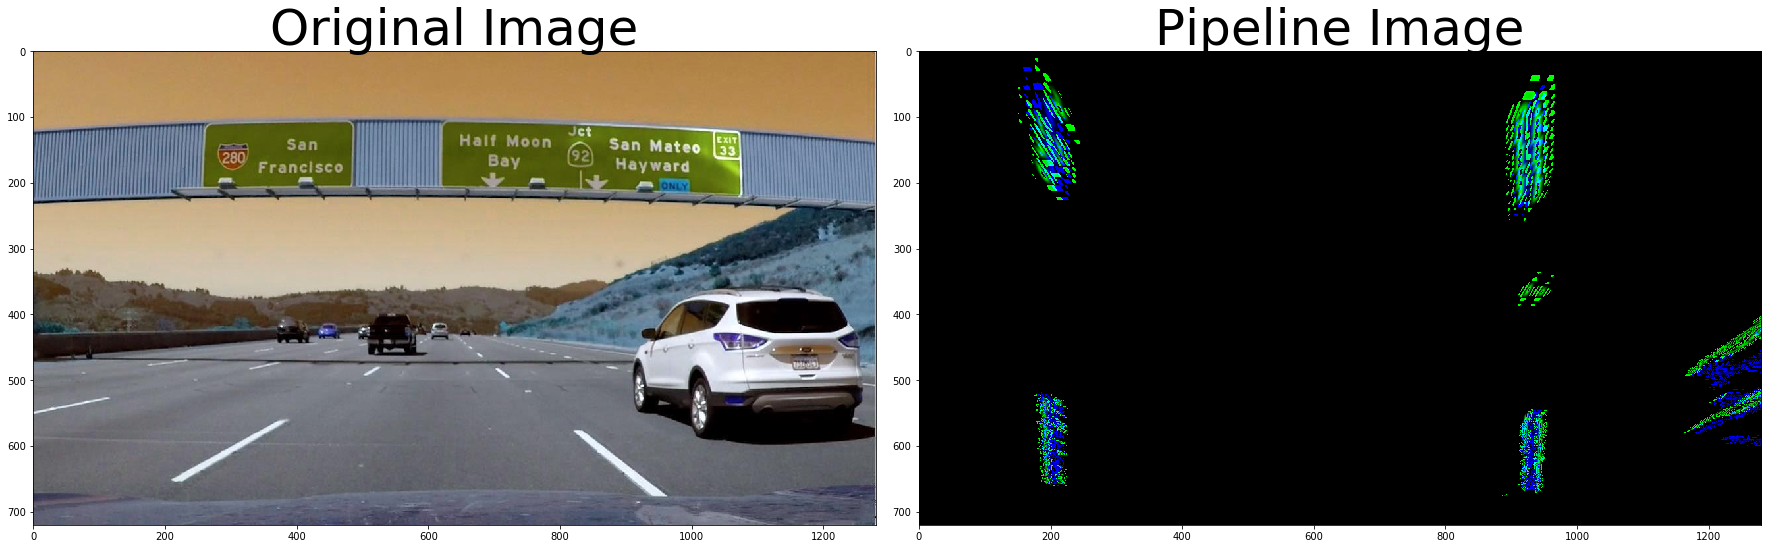

In [74]:

# Test Image to work
test_img = cv2.imread('test_images/udacity.jpg')
height, width, channels = img.shape
print("Size: {}x{}".format(width, height))
##################################################
birds_eye_img, perspective_M, Minv = birds_eye_view(test_img)
##################################################
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(birds_eye_img)
ax2.set_title('Birds Eye View', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

##################################################
birds_eye_img_SB = getHLS(birds_eye_img, 'SB', (90,250))
##################################################
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(getHLS(birds_eye_img, 'S', (90,250)))
ax1.set_title('Birds Eye View "S"', fontsize=50)
ax2.imshow(birds_eye_img_SB)
ax2.set_title('Birds Eye View "SB"', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Test Image to work
##################################################
pipeline_image = pipeline(test_img, s_thresh=(90, 250), sx_thresh=(50, 100))
gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
# appliying perspective matrix
birds_eye_view_pipeline_image = cv2.warpPerspective(getUndistortImage(pipeline_image), perspective_M, gray.shape[::-1], flags=cv2.INTER_LANCZOS4)
##################################################


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(birds_eye_view_pipeline_image)
ax2.set_title('Pipeline Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

test_line = Line()
lines_img, left_fit, right_fit, ploty, left_fitx, right_fitx = test_line.findLines(birds_eye_img_SB)


## Determine the curvature of the lane and vehicle position with respect to center.

In [43]:
# Determine the curvature of the lane and vehicle position with respect to center.
# R
#          [1+(2Ay+B)^2]^3/2
# curve = -------------------
#               ∣2A∣

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image

lines_img, left_fit, right_fit, ploty, leftx, rightx = test_line.findLines(birds_eye_img_SB)

def getBirdsEyeCurve(ploty, leftx, rightx):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, 'px', right_curverad, 'px')
    return left_curverad, right_curverad

# Curveture in Real World (meters)
def getRealWorldCurve(ploty, leftx, rightx):
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    return left_curverad, right_curverad

print("Birds Eye Radius Curve {}".format(getBirdsEyeCurve(ploty, leftx, rightx)))
print("Real World Radius Curve {}".format(getRealWorldCurve(ploty, leftx, rightx)))
print("Real World Radius Curve {}".format(test_line.getRealWorldCurve()))


Birds Eye Radius Curve (90682.566106164901, 8658.4345444327719)
Real World Radius Curve (29776.345737572428, 2840.7581066918829)
Real World Radius Curve (29776.345737572428, 2840.7581066918829)


## Warp the detected lane boundaries back onto the original image

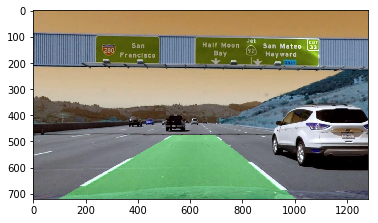

In [44]:
# Warp the detected lane boundaries back onto the original image
def deployBack(src_img, warp_img, Minv, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warp_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (src_img.shape[1], src_img.shape[0])) 
    # Combine the result with the original image
    return cv2.addWeighted(getUndistortImage(src_img), 1, newwarp, 0.3, 0)

plt.imshow(deployBack(test_img, birds_eye_img_SB, Minv, left_fitx, right_fitx, ploty))

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

error: /Users/jenkins/miniconda/1/x64/conda-bld/conda_1486587097465/work/opencv-3.1.0/modules/core/src/matrix.cpp:1052: error: (-215) cn <= 4 in function scalarToRawData


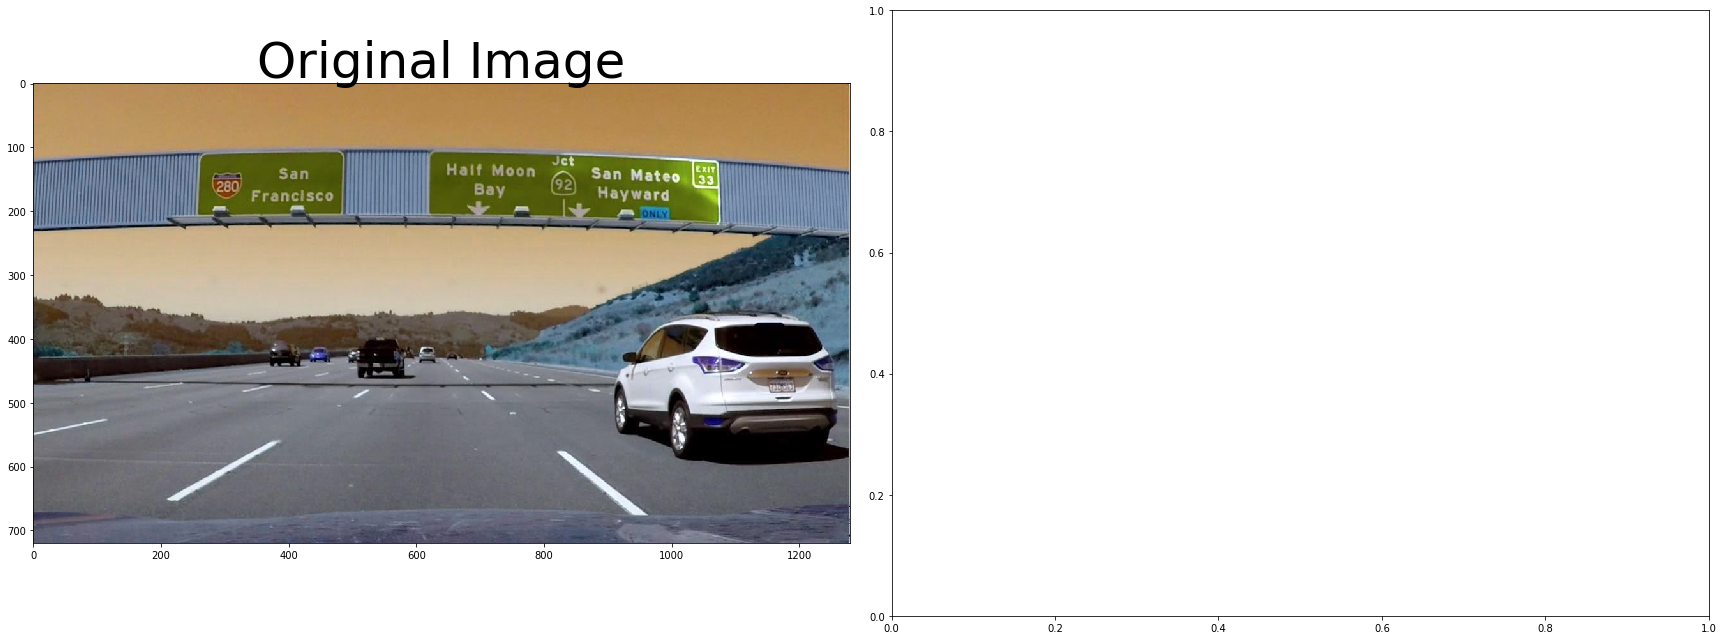

In [69]:
# Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
test_img = cv2.imread('test_images/udacity.jpg')
line = Line()

# keep a buffer with previous lines found, if something is wrong with this actual frame line
# we will use previous frame line
#left_fit_b, right_fit_b, ploty_b, left_fitx_b, right_fitx_b
def process_image(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # 1) Birds Eye View
    birds_img, M, Minv = birds_eye_view(img)
    # 2) Treat image
    pipeline_image = pipeline(img, s_thresh=(90, 250), sx_thresh=(50, 100))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # appliying perspective matrix
    warp_img = cv2.warpPerspective(getUndistortImage(pipeline_image), perspective_M, gray.shape[::-1], flags=cv2.INTER_LANCZOS4)
    #warp_img = getHLS(birds_img, 'SB', (90,250))
    # 2) Find Lines
    out_img, left_fit, right_fit, ploty, left_fitx, right_fitx = line.findLines(warp_img)
    # 3) Flip Back to original Image
    result = deployBack(img, warp_img, Minv, left_fitx, right_fitx, ploty)
    # Put curve info on the imager
    realWorldCurveLeft, realWorldCurveRight = line.getRealWorldCurve()
    text = "Radius of Curvature = {:.2f}(m)".format(realWorldCurveLeft)
    cv2.putText(result, text, (10,50), cv2.FONT_HERSHEY_PLAIN, fontScale=3, thickness=2, color=(255, 255, 255))
    off = line.get_off_center_meters()
    if off < 0:
        text = "Vehicule is {:.2f}(m) left of the center".format(abs(off))
    else:
        text = "Vehicule is {:.2f}(m) right of the center".format(abs(off))
    cv2.putText(result, text, (10,90), cv2.FONT_HERSHEY_PLAIN, fontScale=3, thickness=2, color=(255, 255, 255))
    return result

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(process_image(test_img))
ax2.set_title('Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [46]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [56]:
# Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

clip1_out = 'project_video_processed.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image)
%time project_clip.write_videofile(clip1_out, audio=False)

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4


100%|█████████▉| 1260/1261 [08:07<00:00,  2.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 

CPU times: user 12min 31s, sys: 1min 4s, total: 13min 35s
Wall time: 8min 7s


In [44]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(clip1_out))

In [50]:
# Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

clip2_out = 'harder_challenge_video_processed.mp4'
clip2 = VideoFileClip("harder_challenge_video.mp4")
harder_clip = clip1.fl_image(process_image)
%time harder_clip.write_videofile(clip2_out, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_processed.mp4
[MoviePy] Writing video harder_challenge_video_processed.mp4


100%|█████████▉| 1199/1200 [08:21<00:00,  2.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_processed.mp4 

CPU times: user 12min 49s, sys: 1min 6s, total: 13min 56s
Wall time: 8min 22s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_clip))